In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from sklearn.linear_model import LassoCV
from epftoolbox.evaluation import rMAE
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from jupyterthemes import jtplot

jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)
sns.set()
import warnings
warnings.filterwarnings("ignore")

Curated data retrieved from CENACE

In [2]:
datosraw = pd.read_csv('Gas_PML_Daily_2018_22.csv')
datosraw2 = datosraw.copy()
datosraw2 = datosraw2.drop(columns=['Date'])
df_dateindex = pd.date_range(start='2018-01-02', end='2022-12-31', freq='D')
datosraw2.set_index(df_dateindex, inplace=True)
datosraw2 = datosraw2.loc[(datosraw2.index >= '2020-01-01') & (datosraw2.index <= '2022-12-31')]

Plotting the data separated in test and train datasets

Text(0.5, 0, 'Date')

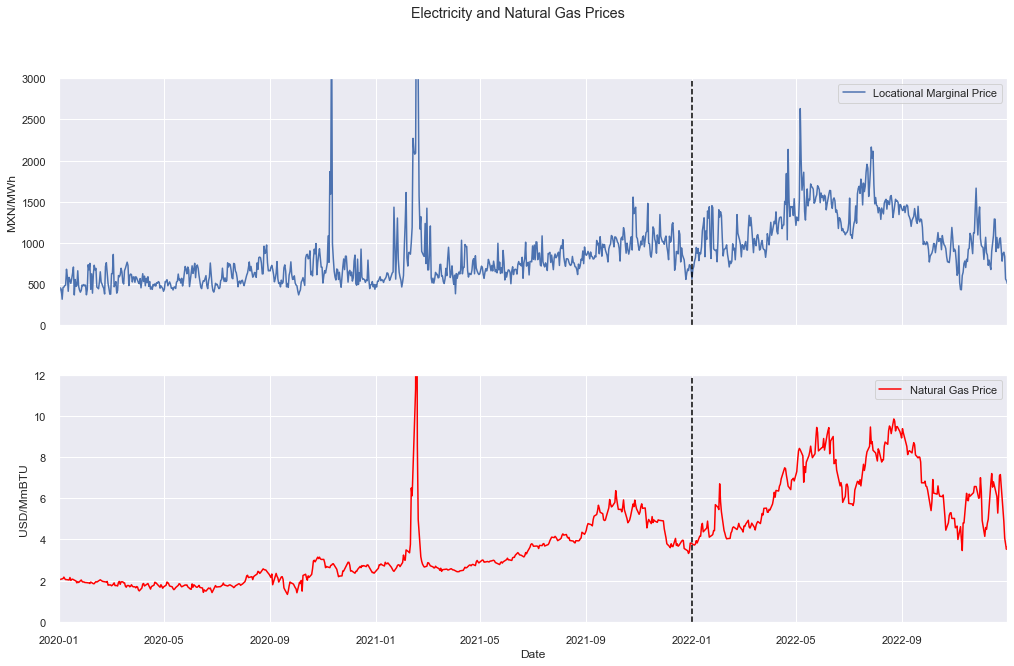

In [3]:
plt.rcParams["figure.figsize"] =[15,10]
fig,(ax1,ax2) = plt.subplots(2, figsize=(17,10),sharex=True)
fig.suptitle('Electricity and Natural Gas Prices')
sns.lineplot(ax=ax1,x=datosraw2.index,y=datosraw2['Precio Electricidad'],label='Locational Marginal Price').set(ylabel = "MXN/MWh")
sns.lineplot(ax=ax2,x=datosraw2.index,y=datosraw2['Precio Gas'],label='Natural Gas Price',color='red').set(ylabel = "USD/MmBTU")
ax1.set_xlim([datetime.date(2020, 1, 1), datetime.date(2022,12,31)])
ax1.set_ylim(0,3000)
ax2.set_ylim(0,12)

ax1.axvline(x=datetime.date(2022, 1, 1),color='black',linestyle='--')
ax2.axvline(x=datetime.date(2022, 1, 1),color='black',linestyle='--')

ax2.set_xlabel('Date')

Function for statistical metrics calculation

In [4]:
def calculate_model_accuracy_metrics(actual, predicted):
    mape = mean_absolute_percentage_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    rmae = rMAE(actual, predicted, m=None, freq='1H')
    smape = 100/len(actual) * np.sum(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted)))
    #return mape*100,mae,mse,rmse,smape
    return mape*100,mae,mse,rmse,smape,rmae

Train test datasets splitting for target and exogenous variables. The splitting was done using the last year of the dataset (2022) as test data and the rest 2 years (from 2020 thru 2021) as training data.

In [5]:
train = datosraw2.loc[(datosraw2.index >= '2020-01-01') & (datosraw2.index <= '2021-12-31')]
train = train.drop(columns=['Precio Gas','Demanda','Eolica','Fotovoltaica','Hidroelectrica'])

test = datosraw2.loc[(datosraw2.index >= '2022-01-01') & (datosraw2.index <= '2022-12-31')]
test = test.drop(columns=['Precio Gas','Demanda','Eolica','Fotovoltaica','Hidroelectrica'])

exog_train = datosraw2.loc[(datosraw2.index >= '2020-01-01') & (datosraw2.index <= '2021-12-31')]
exog_train = exog_train.drop(columns=['Precio Electricidad','Demanda','Eolica','Fotovoltaica','Hidroelectrica'])

exog_test = datosraw2.loc[(datosraw2.index >= '2022-01-01') & (datosraw2.index <= '2022-12-31')]
exog_test = exog_test.drop(columns=['Precio Electricidad','Demanda','Eolica','Fotovoltaica','Hidroelectrica'])

Estimator definition (LassoCV)

In [6]:
# Fit a Lasso regression model to the training data
reg = LassoCV(eps=0.0013,n_alphas=1000,cv=10,random_state=101)
reg.fit(exog_train.values, train.values.ravel())

LassoCV(cv=10, eps=0.0013, n_alphas=1000, random_state=101)

In [7]:
forecast = reg.predict(exog_test.values)

In [8]:
results_LASSO = test.copy()
results_LASSO['prediction'] = forecast

Plotting the comparison between the real and predicted values for the test data

Text(0.5, 0.98, 'EPF using LEAR Model')

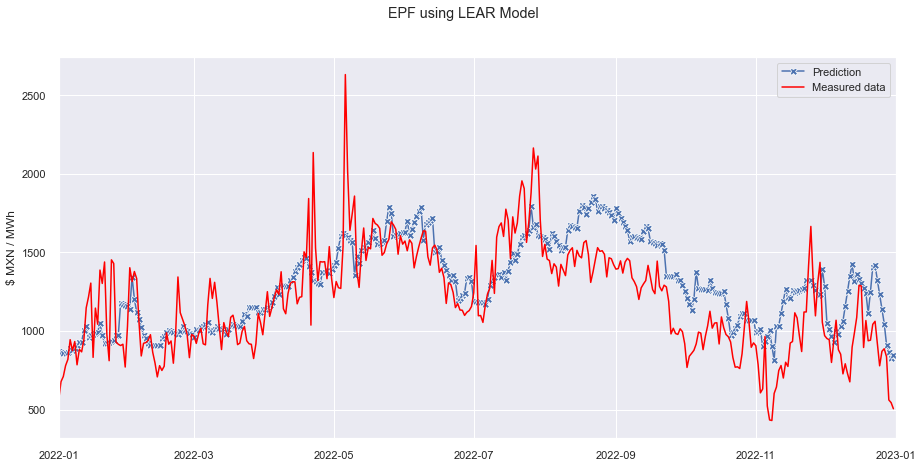

In [9]:
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(x=results_LASSO.index,y=results_LASSO['prediction'],label='Prediction',marker = 'X',markersize=7).set(ylabel = "$ MXN / MWh")
sns.lineplot(x=results_LASSO.index,y=results_LASSO['Precio Electricidad'],label='Measured data',color='red')
ax.set_xlim([datetime.date(2022, 1, 1), datetime.date(2023,1,1)])
ax.legend(loc='upper right')
fig.suptitle('EPF using LEAR Model')

In [10]:
pd.options.display.float_format = '{:.2f}'.format
results_LASSO = results_LASSO.asfreq('d')
#modeloLASSO = pd.DataFrame(data=calculate_model_accuracy_metrics(results_LASSO['Precio Electricidad'],results_LASSO['prediction']), index=['MAPE', 'MAE','MSE','RMSE','sMAPE'])
modeloLASSO = pd.DataFrame(data=calculate_model_accuracy_metrics(results_LASSO['Precio Electricidad'],results_LASSO['prediction']), index=['MAPE', 'MAE','MSE','RMSE','sMAPE','rMAE'])
modeloLASSO.columns = ['Modelo LASSO']
modeloLASSO

,Modelo LASSO
MAPE,18.21
MAE,195.33
MSE,59295.58
RMSE,243.51
sMAPE,16.33
rMAE,1.56


Estimation of predicition intervals for the EPF-LEAR model using the bootstrap method from MAPIE library.

In [11]:
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap

alpha = 0.05
gap = 1

mapie_cv = BlockBootstrap(n_resamplings=10, length=48, overlapping=True, random_state=42)

mapie_enbpi_LASSO = MapieTimeSeriesRegressor(
    reg, method="enbpi", cv=mapie_cv, agg_function="mean", n_jobs=1
)

In [12]:
mapie_enbpi_LASSO = mapie_enbpi_LASSO.fit(exog_train.values, train.values.ravel())
y_pred_npfit_LASSO, y_pis_npfit_LASSO = mapie_enbpi_LASSO.predict(exog_test.values, alpha=alpha,ensemble=True, optimize_beta=True)

In [13]:
mapie_enbpi_LASSO2 = mapie_enbpi_LASSO.fit(exog_train.values, train.values.ravel())
y_pred_pfit_LASSO = np.zeros(y_pred_npfit_LASSO.shape)
y_pis_pfit_LASSO = np.zeros(y_pis_npfit_LASSO.shape)

step_size = 1
(
    y_pred_pfit_LASSO[:step_size],
    y_pis_pfit_LASSO[:step_size, :, :],
) = mapie_enbpi_LASSO2.predict(
    exog_test.iloc[:step_size, :], alpha=alpha, ensemble=True, optimize_beta=True
)

for step in range(step_size, len(exog_test), step_size):
    mapie_enbpi_LASSO2.partial_fit(
        exog_test.iloc[(step - step_size):step, :],
        test.iloc[(step - step_size):step],
    )
    (
        y_pred_pfit_LASSO[step:step + step_size],
        y_pis_pfit_LASSO[step:step + step_size, :, :],
    ) = mapie_enbpi_LASSO2.predict(
        exog_test.iloc[step:(step + step_size), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
    )

Creating a dataframe with predicted average and predicted intervals for the test set

In [14]:
final_LASSO = test.copy()
final_LASSO['pred_pfit'] = y_pred_pfit_LASSO
final_LASSO['pred_uplim_pfit'] = y_pis_pfit_LASSO[:, 1, 0].reshape(-1,1)
final_LASSO['pred_lowlim_pfit'] = y_pis_pfit_LASSO[:, 0, 0].reshape(-1,1)

Plotting actual test data vs predicted data and intervals

(18993.0, 19357.0)

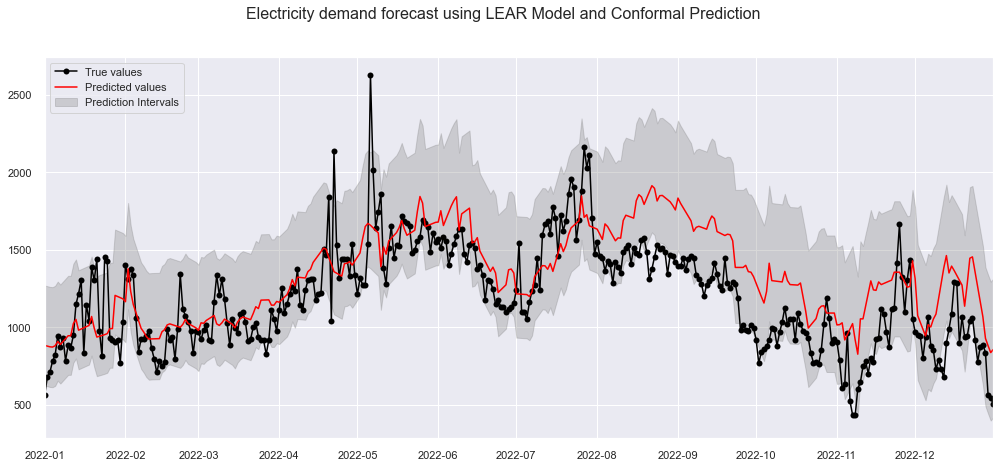

In [15]:
fig, (ax1) = plt.subplots(figsize=(17,7),sharex=True)
fig.suptitle('Electricity demand forecast using LEAR Model and Conformal Prediction', fontsize=16)
ax1.plot(final_LASSO.index, final_LASSO['Precio Electricidad'], marker='o', label="True values", color='black')
ax1.plot(final_LASSO.index, final_LASSO['pred_pfit'].values, label="Predicted values", color='red')
ax1.fill_between(
    final_LASSO.index,
    final_LASSO['pred_uplim_pfit'].values,
    final_LASSO['pred_lowlim_pfit'].values,
    alpha=0.3,
    label="Prediction Intervals",
    color='gray'
)
ax1.legend(loc='upper left')
ax1.set_xlim([datetime.date(2022, 1, 1), datetime.date(2022,12,31)])

Calculating metrics for predicted intervals

In [16]:
from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)

In [17]:
coverage = regression_coverage_score(final_LASSO['Precio Electricidad'].values, final_LASSO['pred_lowlim_pfit'].values, final_LASSO['pred_uplim_pfit'].values)
width = regression_mean_width_score(final_LASSO['pred_lowlim_pfit'].values, final_LASSO['pred_uplim_pfit'].values)

In [18]:
pd.options.display.float_format = '{:.2f}'.format
PI_display = pd.DataFrame(data=(coverage, width), index=['Coverage', 'Width'])
PI_display.columns = ['LEAR Model']
PI_display

,LEAR Model
Coverage,0.84
Width,780.34
